# Retail Transaction Analysis using Market Basket Analysis

This project analyzes retail transaction data to identify frequently purchased product combinations using association rule mining. The insights derived can be used for cross-selling, product bundling, and recommendation strategies.


## Dataset Description

The dataset contains transactional data from a retail store.  
Each row represents a product purchased in a specific invoice.

### Key Columns:
- **InvoiceNo:** Unique identifier for each transaction
- **StockCode:** Unique identifier for each product
- **Description:** Product description
- **Quantity:** Number of units purchased
- **InvoiceDate:** Date and time of purchase
- **UnitPrice:** Price per unit
- **CustomerID:** Unique customer identifier
- **Country:** Customer location


## Business Problem

Retail businesses need to understand customer purchasing behavior to improve sales and customer experience.  
The goal of this project is to identify products that are frequently bought together so that businesses can:
- Design effective cross-selling strategies
- Create product bundles
- Improve recommendation systems


## Loading Dataset and Essential Libary

In [51]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel(r"C:\Users\editi\Downloads\Online Retail.xlsx")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [52]:
df = df.dropna(subset=['CustomerID'])


In [53]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]


In [54]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [55]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)


In [57]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'UnitPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,1.04
12347.0,2,7,481.21
12348.0,75,4,178.71
12349.0,19,1,605.10
12350.0,310,1,65.30


In [58]:
rfm.describe()


,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,285.846154
std,100.014169,7.697998,880.636531
min,1.000000,1.000000,0.170000
25%,18.000000,1.000000,51.725000
50%,51.000000,2.000000,127.290000
75%,142.000000,5.000000,294.452500
max,374.000000,209.000000,33332.450000


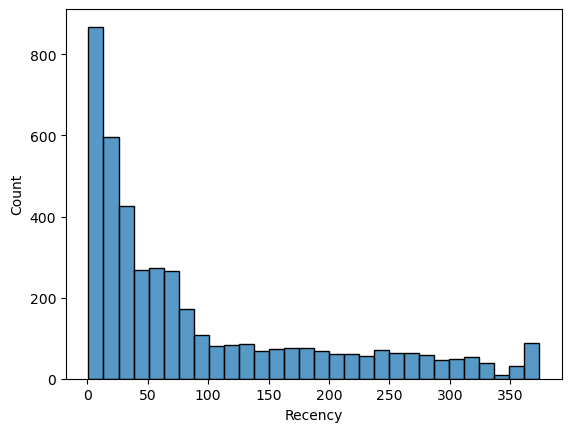

In [59]:
sns.histplot(rfm['Recency'], bins=30)
plt.show()


In [ ]:
# scaling 

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


## Optimal K by Elbow Method & Silhoutte 

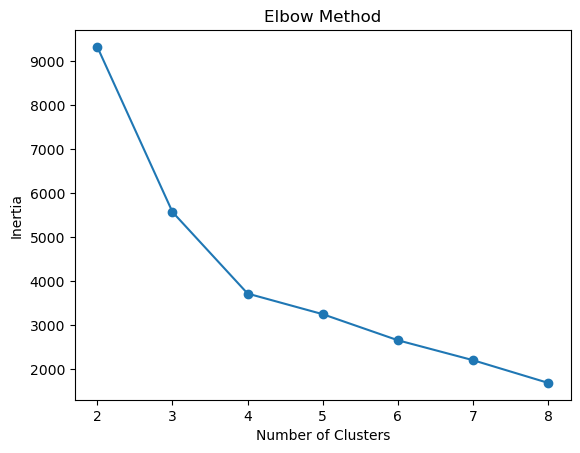

In [61]:
from sklearn.cluster import KMeans

inertia = []
for k in range(2,9):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2,9), inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


In [62]:
from sklearn.metrics import silhouette_score

for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f"K={k}, Silhouette Score={score:.3f}")


K=2, Silhouette Score=0.543
K=3, Silhouette Score=0.563
K=4, Silhouette Score=0.598
K=5, Silhouette Score=0.426
K=6, Silhouette Score=0.482


## Applying K means 

In [63]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [64]:
rfm.groupby('Cluster').mean().round(2)


,Recency,Frequency,Monetary
Cluster,,,
0,43.85,3.74,239.29
1,248.93,1.54,95.79
2,2.00,137.75,22893.06
3,12.12,24.62,1584.15


Cluster 2 (VIP Customers): Extremely frequent and high-spending customers with very recent purchases, representing the most valuable customer segment.

Cluster 3 (Loyal Customers): Regular purchasers with strong monetary contribution and high engagement.

Cluster 0 (Regular Customers): Moderate spending customers with growth potential through targeted promotions.

Cluster 1 (At-Risk Customers): Infrequent buyers with long purchase gaps, indicating high churn risk.

 ## Business Recommendations

VIP Customers: Provide exclusive offers, loyalty rewards, and early access to products

Loyal Customers: Upsell and cross-sell through personalized recommendations

Regular Customers: Encourage higher engagement using targeted discounts

At-Risk Customers: Run win-back campaigns and reminder emails

## PCA visualization

In [66]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
rfm_pca = pca.fit_transform(rfm_scaled)

pca_df = pd.DataFrame(rfm_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = rfm['Cluster']


In [69]:
pca_df.columns


Index(['PC1', 'PC2', 'Cluster'], dtype='object')

In [75]:
# Recreate PCA DataFrame
pca_df = pd.DataFrame(
    rfm_pca,
    columns=['PC1', 'PC2']
)

# IMPORTANT: use .values to avoid index mismatch
pca_df['Cluster'] = rfm['Cluster'].values


In [76]:
pca_df.isna().sum()


PC1        0
PC2        0
Cluster    0
dtype: int64

## Customer Segmentation Visualisation with Centroid  

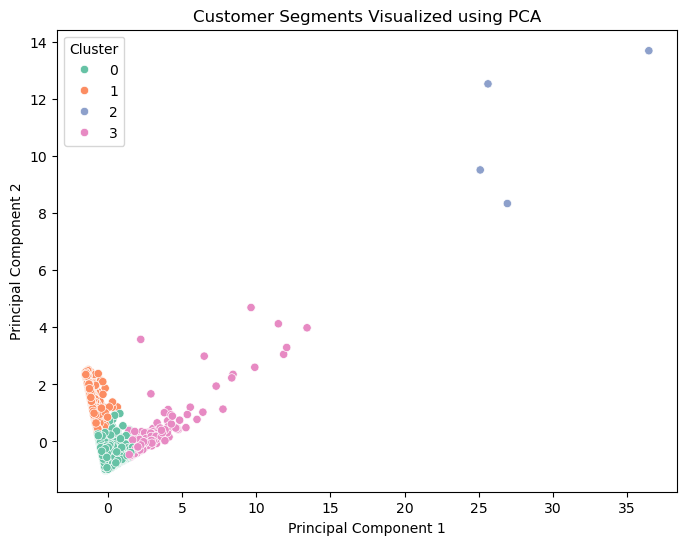

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='Set2',
    data=pca_df
)
plt.title("Customer Segments Visualized using PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.show()


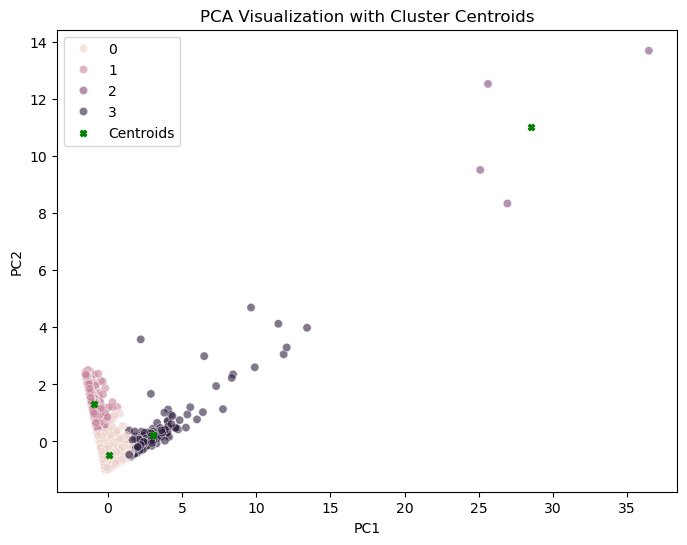

In [82]:
centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Cluster',
    data=pca_df,
    alpha=0.6
)

plt.scatter(
    centroids_pca[:,0],
    centroids_pca[:,1],
    s=20,
    c='green',
    marker='K',
    label='Centroids'
)

plt.title("PCA Visualization with Cluster Centroids")
plt.legend()
plt.show()


### This project demonstrates how transactional retail data can be transformed into actionable customer insights using RFM analysis and K-Means clustering. The resulting segments enable data-driven marketing strategies, improved customer retention, and revenue optimization.